# Training Process Outlines

* **This file is just an illustraion**
* **Most of the training are done via command lines tools**

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from model import fishnet99, fishnet55

from model.blocks import *

%load_ext autoreload
%autoreload 2

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Data Import & Preprocessing

In [3]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist

## Load Data
# Load the raw data.
train, test = cifar10.load_data()
#train, test = mnist.load_data()
#train, test = cifar100.load_data()

X_train_raw, y_train_raw = train
X_test_raw, y_test_raw = test

In [20]:
# Data organizations:
# Train data: 1900 samples from original train set: 1~1,900
# Validation data: 100 samples from original train set: 1,900~2,000
# Test data: 500 samples from original test set: 1~500
num_training = 1900
num_validation = 100
num_test = 500

X_train_subset = X_train_raw[:(num_training+num_validation), :]
y_train_subset = y_train_raw[:(num_training+num_validation)]

X_train_sub = X_train_subset[:num_training, :]
y_train_sub = y_train_subset[:num_training]

X_val_sub = X_train_subset[-num_validation:, :]
y_val_sub = y_train_subset[-num_validation:]

X_test_sub = X_test_raw[:num_test, :]
y_test_sub = y_test_raw[:num_test]

# Check Data Shape
print(X_train_sub.shape, X_val_sub.shape, X_test_sub.shape)
print('Train data shape: ', X_train_sub.shape)
print('Train labels shape: ', y_train_sub.shape)
print('Validation data shape: ', X_val_sub.shape)
print('Validation labels shape: ', y_val_sub.shape)
print('Test data shape: ', X_test_sub.shape)
print('Test labels shape: ', y_test_sub.shape)

(1900, 32, 32, 3) (100, 32, 32, 3) (500, 32, 32, 3)
Train data shape:  (1900, 32, 32, 3)
Train labels shape:  (1900, 1)
Validation data shape:  (100, 32, 32, 3)
Validation labels shape:  (100, 1)
Test data shape:  (500, 32, 32, 3)
Test labels shape:  (500, 1)


16 Random images and their labels


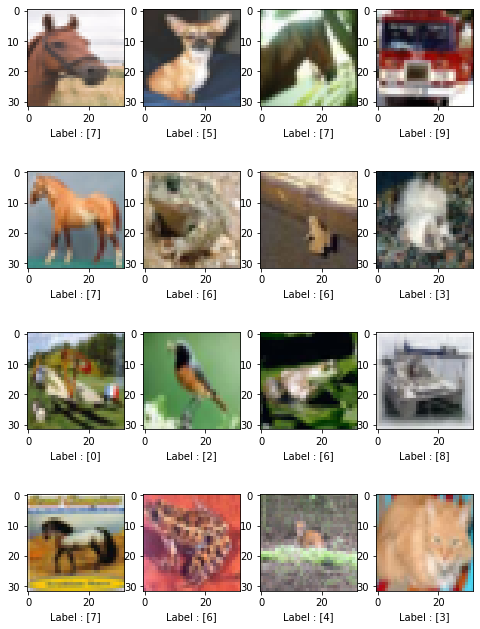

In [21]:
## Data Visualization
# cifar10: [0]airplane, [1]automobile, [2]bird, [3]cat, [4]deer, [5]dog, [6]frog, [7]horse, [8]ship, [9]truck
# Preview random image
from imgprocess import plot

plot(X_test_sub, y_test_sub)

In [22]:
## Preprocess
# Data Resize
from imgprocess import resize
#resize(x, shape = (,,)

shape = (56,56,3)
#shape = (224,224,3)
X_train_resize = resize(X_train_sub, shape)
X_val_resize = resize(X_val_sub, shape)
X_test_resize = resize(X_test_sub, shape)

In [23]:
#X_train_resize = X_train_sub.reshape(X_train_sub.shape[0],28,28,1)
#X_val_resize = X_val_sub.reshape(X_val_sub.shape[0],28,28,1)
#X_test_resize = X_test_sub.reshape(X_test_sub.shape[0],28,28,1)

# Check Data Shape
print('Train data shape: ', X_train_resize.shape)
print('Validation data shape: ', X_val_resize.shape)
print('Test data shape: ', X_test_resize.shape)

Train data shape:  (1900, 56, 56, 3)
Validation data shape:  (100, 56, 56, 3)
Test data shape:  (500, 56, 56, 3)


In [24]:
# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train_resize, axis=0)

X_train = X_train_resize.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val_resize.astype(np.float32) - mean_image
X_test = X_test_resize.astype(np.float32) - mean_image

##################### mnist #########################
#X_train = X_train.reshape((X_train_resize.shape[0],56,56,1))
#X_val = X_val.reshape((X_val_resize.shape[0],56,56,1))
#X_test = X_test.reshape((X_test_resize.shape[0],56,56,1))

y_train = y_train_sub
y_val = y_val_sub
y_test = y_test_sub

# Check Data Shape
print(X_train.shape, X_val.shape, X_test.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

(1900, 56, 56, 3) (100, 56, 56, 3) (500, 56, 56, 3)
Train data shape:  (1900, 56, 56, 3)
Train labels shape:  (1900, 1)
Validation data shape:  (100, 56, 56, 3)
Validation labels shape:  (100, 1)
Test data shape:  (500, 56, 56, 3)
Test labels shape:  (500, 1)


16 Random images and their labels


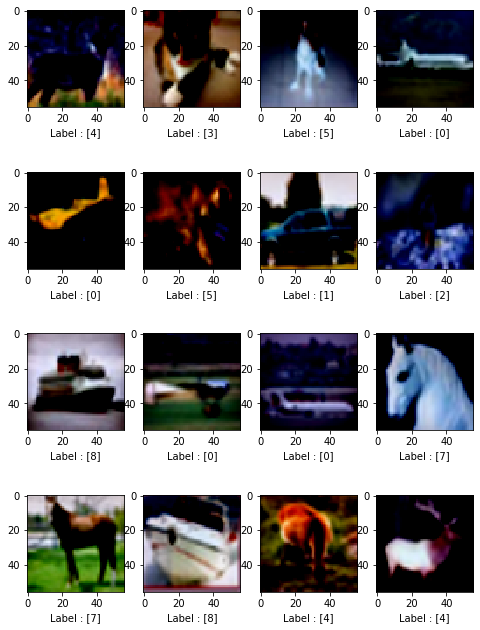

In [25]:
## Data Visualization
#Preview random image
plot(X_val,y_val)

## Block Tests

In [10]:
## block test
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.Input(shape=shape), 
    StgBlock(True, 3, 8, 3, 2, (1, 1), False), 
    ScrBlock(8, 100, has_pool=True)
])
model.compile(
    optimizer=tf.keras.optimizers.SGD(1e-3, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stg_block (StgBlock)         (None, 28, 28, 8)         354       
_________________________________________________________________
scr_block (ScrBlock)         (None, 100)               313780    
Total params: 314,134
Trainable params: 314,042
Non-trainable params: 92
_________________________________________________________________


In [11]:
model.fit(
    x=X_train, y=y_train, verbose=1, 
    batch_size=32, epochs=30, 
    validation_data=(X_val, y_val)
)

Epoch 1/30
60/60 [==============================] - 5s 19ms/step - loss: 4.2308 - accuracy: 0.0935 - val_loss: 3.8392 - val_accuracy: 0.0900
Epoch 2/30
60/60 [==============================] - 1s 8ms/step - loss: 2.1367 - accuracy: 0.2699 - val_loss: 3.4703 - val_accuracy: 0.1000
Epoch 3/30
60/60 [==============================] - 1s 8ms/step - loss: 1.8863 - accuracy: 0.3467 - val_loss: 3.2222 - val_accuracy: 0.1200
Epoch 4/30
60/60 [==============================] - 0s 8ms/step - loss: 1.7898 - accuracy: 0.3871 - val_loss: 2.7416 - val_accuracy: 0.1600
Epoch 5/30
60/60 [==============================] - 0s 8ms/step - loss: 1.5618 - accuracy: 0.4641 - val_loss: 2.4984 - val_accuracy: 0.2300
Epoch 6/30
60/60 [==============================] - 1s 8ms/step - loss: 1.4161 - accuracy: 0.5035 - val_loss: 2.1344 - val_accuracy: 0.3600
Epoch 7/30
60/60 [==============================] - 0s 8ms/step - loss: 1.2697 - accuracy: 0.5946 - val_loss: 2.1055 - val_accuracy: 0.3600
Epoch 8/30
60/60 [=

In [12]:
# tail model
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        #################### down, i, o, n, k, di,     tr
        self.stg1 = StgBlock(True, 3, 8, 3, 2, (1, 1), False)
        self.stg2 = StgBlock(True, 8, 16, 3, 2, (1, 1), False)
        self.stg3 = StgBlock(True, 16, 32, 3, 2, (1, 1), False)
        self.scr = ScrBlock(32, 32)
        self.se = SeBlock(32, 32)
    def call(self, x):
        x = self.stg1(x)
        x = self.stg2(x)
        scr = self.scr(x)
        se = self.se(scr)
        out = self.stg3(scr) * se + se
        return out

In [13]:
## tail test
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.Input(shape=shape), 
    Model(), 
    ScrBlock(32, 100, has_pool=True)
])
model.compile(
    optimizer=tf.keras.optimizers.SGD(1e-3, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 32)          7764      
_________________________________________________________________
scr_block_1 (ScrBlock)       (None, 100)               79204     
Total params: 86,968
Trainable params: 86,180
Non-trainable params: 788
_________________________________________________________________


In [14]:
model.fit(
    x=X_train, y=y_train, verbose=1, 
    batch_size=32, epochs=30, 
    validation_data=(X_val, y_val)
)

Epoch 1/30
60/60 [==============================] - 5s 31ms/step - loss: 5.2387 - accuracy: 0.0151 - val_loss: 4.5333 - val_accuracy: 0.0000e+00
Epoch 2/30
60/60 [==============================] - 1s 16ms/step - loss: 3.5106 - accuracy: 0.1717 - val_loss: 3.8618 - val_accuracy: 0.1400
Epoch 3/30
60/60 [==============================] - 1s 16ms/step - loss: 2.3744 - accuracy: 0.2313 - val_loss: 2.9224 - val_accuracy: 0.1000
Epoch 4/30
60/60 [==============================] - 1s 16ms/step - loss: 2.1699 - accuracy: 0.2475 - val_loss: 2.3478 - val_accuracy: 0.1900
Epoch 5/30
60/60 [==============================] - 1s 16ms/step - loss: 1.9878 - accuracy: 0.2969 - val_loss: 2.2356 - val_accuracy: 0.1700
Epoch 6/30
60/60 [==============================] - 1s 16ms/step - loss: 1.9168 - accuracy: 0.3372 - val_loss: 2.1381 - val_accuracy: 0.2400
Epoch 7/30
60/60 [==============================] - 1s 16ms/step - loss: 1.7965 - accuracy: 0.3677 - val_loss: 2.0631 - val_accuracy: 0.2500
Epoch 8/3

## Train Model

In [4]:
from imgprocess import make_dataset
batch_size = 64
train_set, val_set = make_dataset(train, test, batch_size)

In [5]:
## Summary
tf.keras.backend.clear_session()
model = fishnet55(num_cls=10, input_shape=(56,56,3))
model.summary()

Model: "fishnet_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
fish_net (FishNet)           (None, 10)                118752    
Total params: 118,752
Trainable params: 116,040
Non-trainable params: 2,712
_________________________________________________________________


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(1e-3, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)
hist = model.fit(
    x=train_set, verbose=1, 
    batch_size=batch_size, epochs=20, 
    validation_data=val_set
)

Epoch 1/20
782/782 [==============================] - 70s 65ms/step - loss: 2.1927 - accuracy: 0.2938 - val_loss: 1.7192 - val_accuracy: 0.4272
Epoch 2/20
782/782 [==============================] - 49s 62ms/step - loss: 1.5262 - accuracy: 0.4728 - val_loss: 1.4471 - val_accuracy: 0.4999
Epoch 3/20
782/782 [==============================] - 49s 63ms/step - loss: 1.3063 - accuracy: 0.5422 - val_loss: 1.4173 - val_accuracy: 0.5215
Epoch 4/20
782/782 [==============================] - 49s 62ms/step - loss: 1.2077 - accuracy: 0.5738 - val_loss: 1.2750 - val_accuracy: 0.5564
Epoch 5/20
782/782 [==============================] - 49s 62ms/step - loss: 1.1152 - accuracy: 0.6046 - val_loss: 1.2052 - val_accuracy: 0.5719
Epoch 6/20
782/782 [==============================] - 49s 62ms/step - loss: 1.0425 - accuracy: 0.6350 - val_loss: 1.2404 - val_accuracy: 0.5708
Epoch 7/20
782/782 [==============================] - 49s 62ms/step - loss: 0.9998 - accuracy: 0.6451 - val_loss: 1.1163 - val_accuracy:

In [31]:
import pickle
from datetime import datetime
import os
path = os.path.join('./history', datetime.now().strftime('%m-%d-%H:%M:%S'))
with open(path, 'wb') as f:
    pickle.dump(hist.history, f)

In [32]:
with open(path, 'rb') as f:
    h = pickle.load(f)

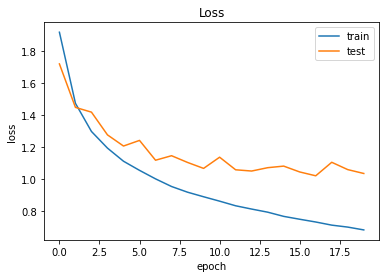

In [33]:
# Plot loss
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

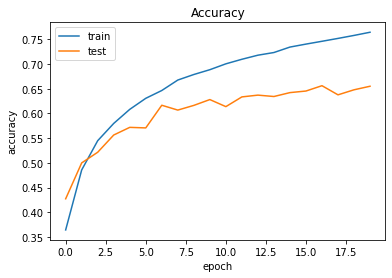

In [34]:
# Plot accuracy
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Self Implemented Train Function

In [28]:
## Train
def train():
    # Define parameters
    num_train = X_train.shape[0]
    learning_rate = 1e-3
    batch_size = 32
    num_batch = num_train//batch_size
    num_epochs = 5

    # Define loss function
    criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Define optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    # Deine the metrics
    # Top-1 accuracy
    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)


    # Test training for several epochs
    model = fishnet55(num_cls=10, input_shape=(56, 56, 3))
    # Compile model
    model.compile(
        optimizer=optimizer, 
        loss=criterion, 
        metrics=[train_acc_metric, val_acc_metric]
    )

    for epoch in range(num_epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                output = model(x_batch_train)
                loss_value = criterion(y_batch_train, output)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Update training metric.
            train_acc_metric.update_state(y_batch_train, output)

            # Log every 100 batches.
            if step % 100 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                print("Seen so far: %d samples" % ((step + 1) * batch_size))

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_output = model(x_batch_val)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_output)
        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))